## Espectro teórico

Calculamos el espectro de potencias teórico usando el paquete [**CAMB**](https://camb.readthedocs.io/en/latest/) de python.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower

print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.0.5 installed at /home/ornela/.local/lib/python3.6/site-packages/camb


Vamos a setear los parámetros cosmológicos con los valores obtenidos por [PLANCK IV](https://arxiv.org/pdf/1807.06209.pdf)

In [8]:
# Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=  67.4, ombh2= 0.0224, omch2= 0.120, mnu=0.12, omk=0.001, tau=0.054)
pars.InitPower.set_params(As= 2.100e-9, ns= 0.965, r=0)
pars.set_for_lmax(1000, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


Graficamos el espectro de potencias del CMB

(0, 1000)

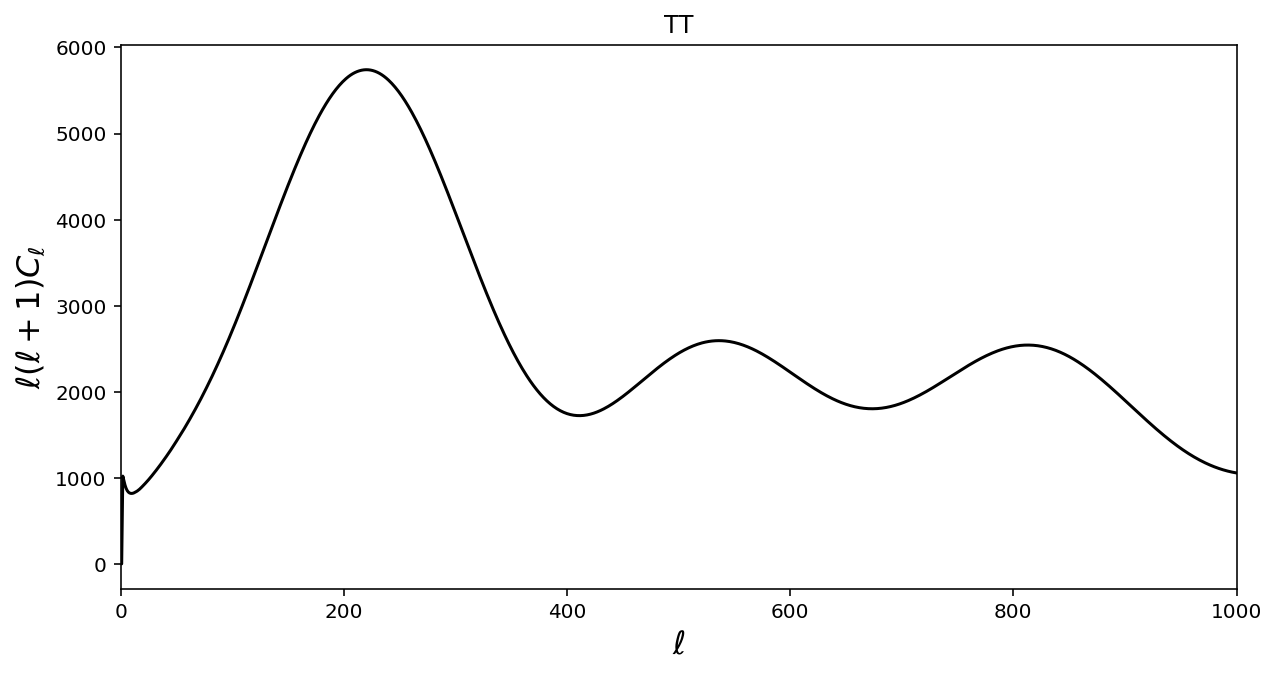

In [9]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
# print(totCL.shape)

#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(ls,totCL[:,0], color='k')
plt.xlabel("$\ell$", fontsize = 16)
plt.ylabel("$\ell(\ell+1)C_{\ell}$", fontsize = 16)
plt.title('TT')
plt.xlim(0,1000)

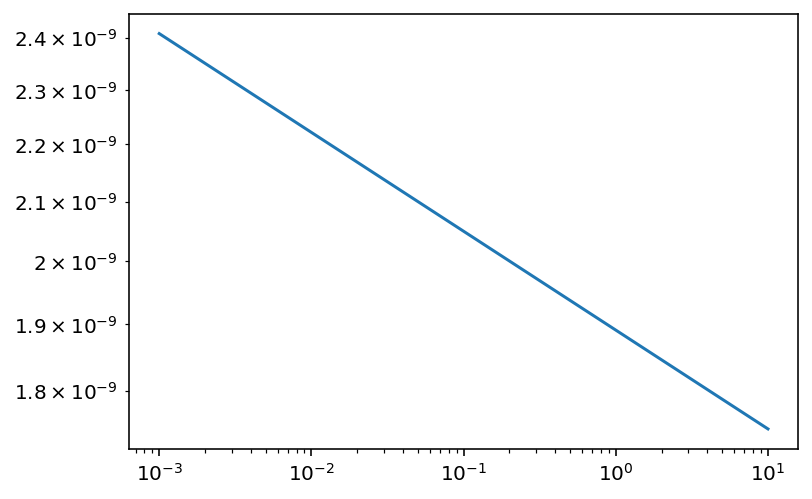

In [20]:
# k = np.linspace(0.001,10, 100)
# func = pars.scalar_power(k)
# # print (func)
# plt.plot(k, func)
# plt.xscale('log')
# plt.yscale('log')

## Espectro observacional

Buscamos los mapas del CMB en la página de [PLANCK](https://pla.esac.esa.int/#home) y calculamos el espectro obsevacional a partir de estos datos utilizando el paquete [HEALPY](https://healpy.readthedocs.io/en/latest/index.html) de python.

In [4]:
import healpy as hp
planck_map_I  = hp.read_map("COM_CMB_IQU-nilc_2048_R3.00_full.fits")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/ornela/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


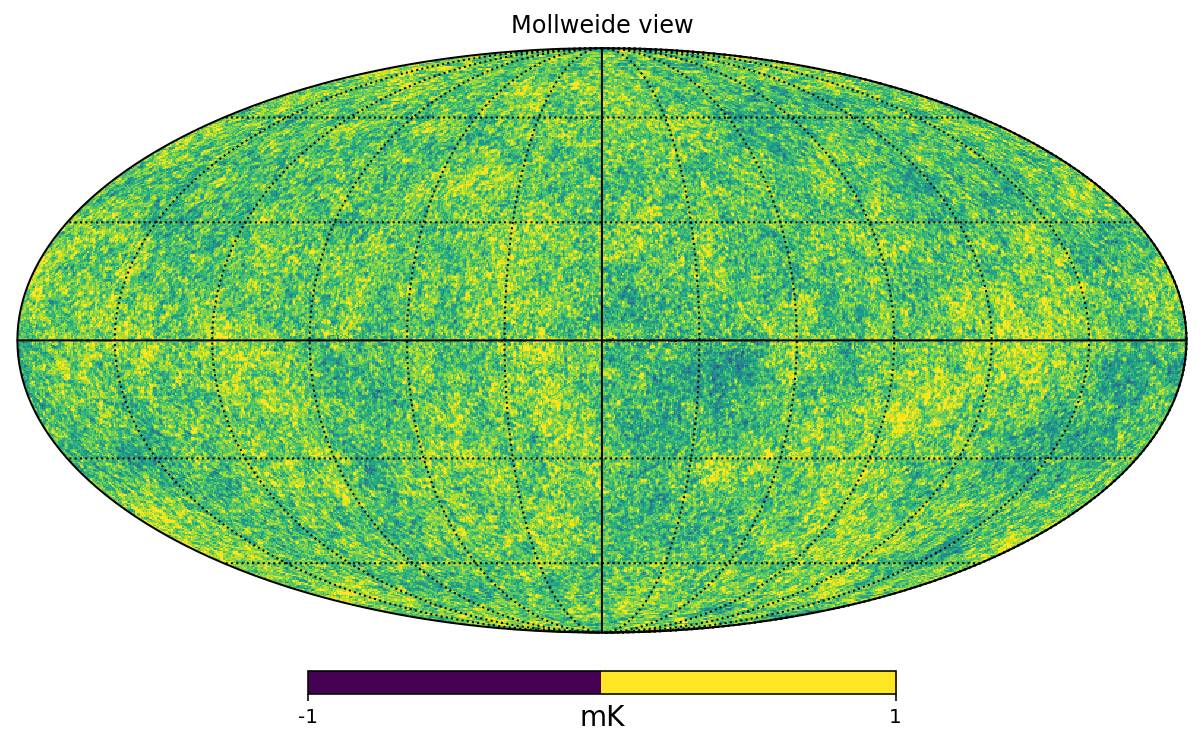

In [6]:
hp.mollview(
    planck_map_I,
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
hp.graticule()

Utilizamos la rutina [anafast](https://healpy.readthedocs.io/en/latest/generated/healpy.sphtfunc.anafast.html#healpy.sphtfunc.anafast) de healpy para calcular los $\ell$ y los $C_{\ell}$ 

In [7]:
LMAX = 1024
cl = hp.anafast(planck_map_I, lmax=LMAX)
# ell = np.arange(len(cl))

In [8]:
def correccion(cl):
    lls= np.arange(len(cl)) 
    bls =  np.exp(-lls**2*np.radians(5./60/2.35)**2/2)
    pixwins=hp.pixwin(2048)[0:len(lls)]
    dlspice  = cl * lls * (lls+1) / 2/ np.pi / pixwins**2 / bls**2
    cll = cl / (pixwins**2 * bls**2)
    return lls, dlspice, cll

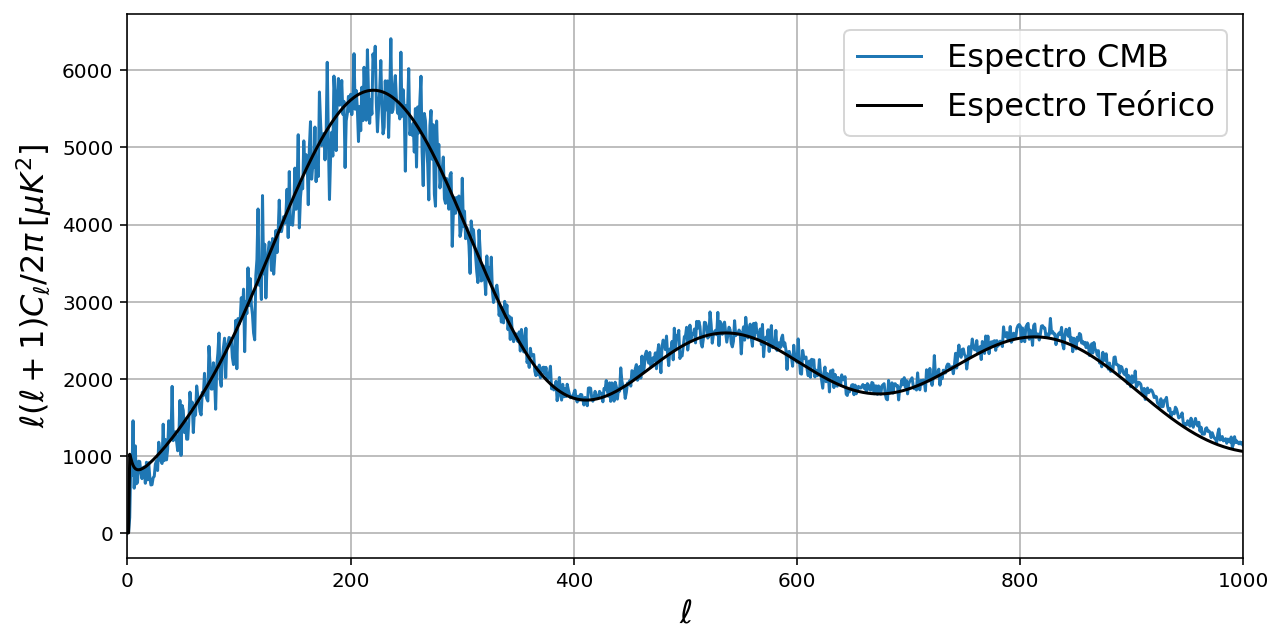

In [9]:
dlspice = correccion(cl)[1]
lls = correccion(cl)[0]

plt.figure(figsize=(10, 5))
plt.plot(lls, dlspice*1e12, label= 'Espectro CMB')
plt.plot(ls,totCL[:,0], color='k', label='Espectro Teórico')
plt.xlim(0,1000)
plt.xlabel("$\ell$", fontsize = 16)
plt.ylabel("$\ell(\ell+1)C_{\ell}/2 \pi\:[\mu K^{2}] $", fontsize = 16)
plt.grid()
plt.legend(fontsize = 16)
hp.write_cl("cl.fits", cl, overwrite=True)

### Análisis del paper de [Melia & López-Correidora, 2017](https://arxiv.org/pdf/1712.07847.pdf)

Vamos a comparar los datos teóricos y los observacionales para las escalas pequeñas

Hacemos el mismo plot que el anterior pero para los $\ell$ chiquitos

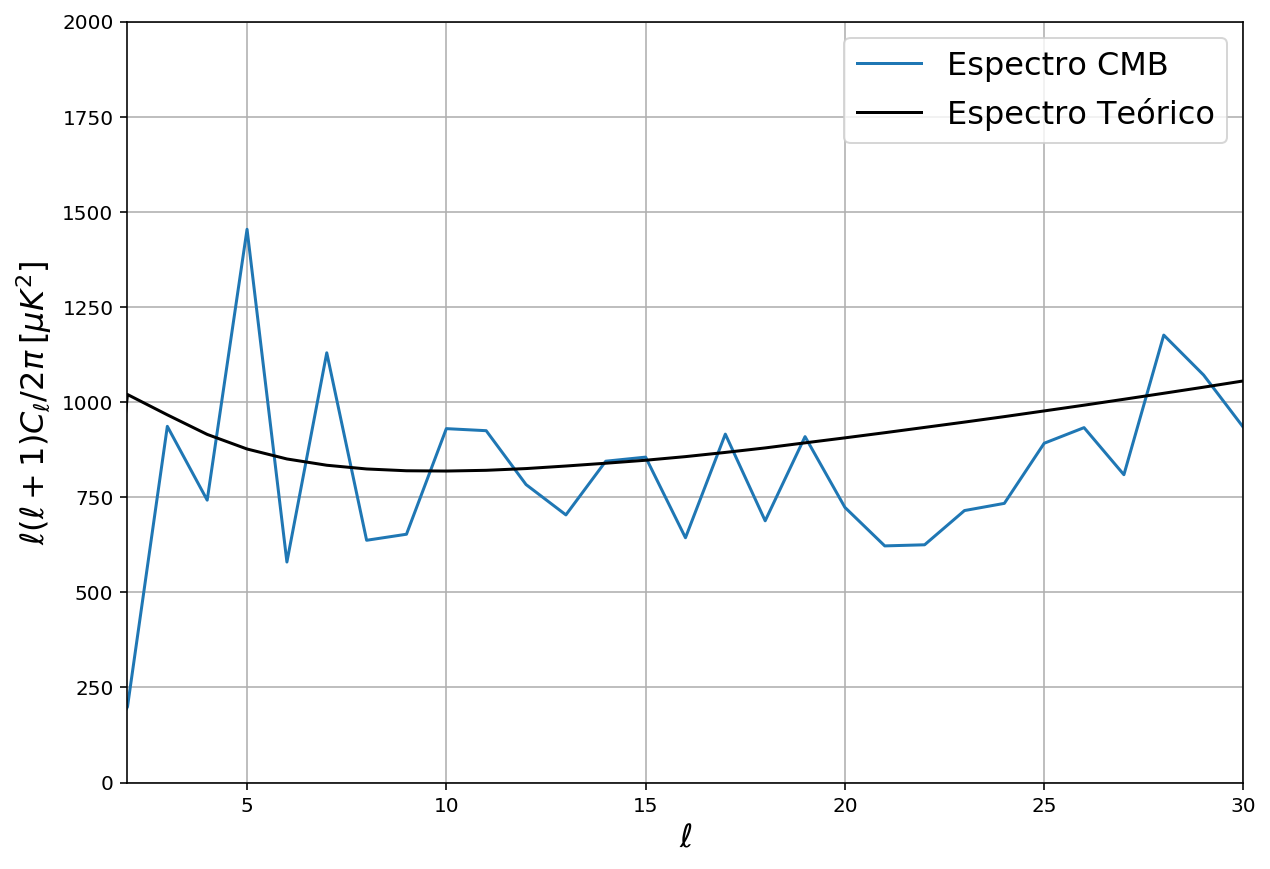

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(lls, dlspice*1e12, label= 'Espectro CMB')
plt.plot(ls,totCL[:,0], color='k', label='Espectro Teórico')
plt.xlim(2,30)
plt.ylim(0,2000)
plt.xlabel("$\ell$", fontsize = 16)
plt.ylabel("$\ell(\ell+1)C_{\ell}/2 \pi\:[\mu K^{2}]$", fontsize = 16)
plt.grid()
plt.legend(fontsize = 16)
hp.write_cl("cl.fits", cl, overwrite=True)

Defino una función para calcular los $C(cos(\theta))$

In [11]:
from scipy.special import legendre

def Ccost(cost, l, cl):
    Ccost = 0
    for i in range(len(l)):
        Pl = legendre(l[i])
        Ccost = Ccost + (2.*l[i] +1)*cl[i]*Pl(cost)
    
    Ccost = Ccost/(4*np.pi)
    return Ccost

Espectro Observacional:

In [12]:
LMAX = 30
cl2 = hp.anafast(planck_map_I, lmax=LMAX)

In [13]:
ls1 = correccion(cl2)[0]
cl1 = correccion(cl2)[2]

In [14]:
mask_obs = np.where((ls1>2) & (ls1<30))
lls2  = ls1[mask_obs]
cls2  = cl1[mask_obs] 

cost = np.arange(-1,1,0.001)

x = np.arccos(cost)
y1 = Ccost(cost, lls2, cls2*1e12)

Espectro Teórico:

In [15]:
lss = ls[1:]
dl  = totCL[1:,0]
ccl =  dl*2*np.pi/(lss*(lss+1))

y2 = Ccost(cost, lss, ccl)

/home/ornela/.local/lib/python3.6/site-packages/scipy/special/orthogonal.py:141: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/ornela/.local/lib/python3.6/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/ornela/.local/lib/python3.6/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/ornela/.local/lib/python3.6/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: overflow encountered in power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


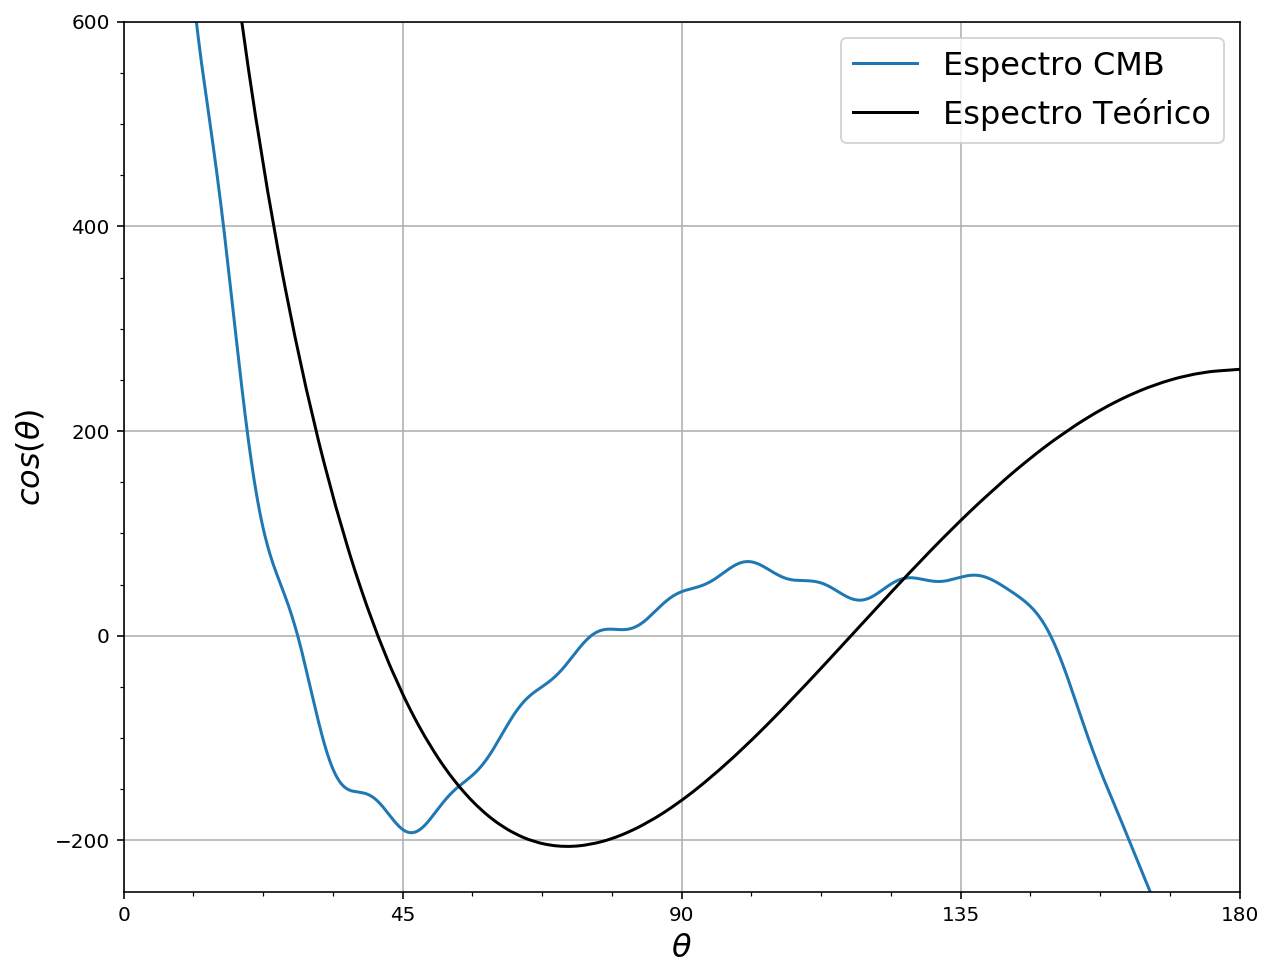

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(x*180/np.pi, y1, label= 'Espectro CMB')
plt.plot(x*180/np.pi, y2, color='k', label='Espectro Teórico')
plt.xlim(2,180)
plt.ylim(-250,600)
plt.xlabel("$ \\theta $", fontsize = 16)
plt.ylabel("$cos(\\theta)$", fontsize = 16)
plt.xticks([0,45,90,135,180])
plt.yticks([-200,0,200,400,600])
plt.minorticks_on()
plt.grid()
plt.legend(fontsize = 16)

In [3]:
def P0(k):
    As = 2.1e-9
    ns = 0.965
    P0 = As * k**ns
    return P0

def P(k):
    a  = 1.8
    kc = 5.5e-4
    P = P0(k) * (1. - np.exp(-(k/kc)**a))
    return P

In [25]:
import numpy as np
k = np.linspace(0.001,10, 10)

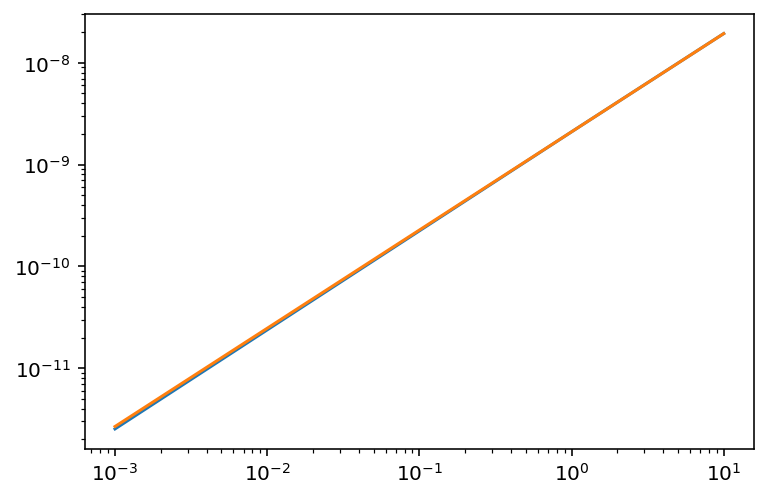

In [26]:
import matplotlib.pyplot as plt
plt.plot(k, P(k))
plt.plot(k,P0(k))
plt.yscale('log')
plt.xscale('log')

In [4]:
import camb
from camb import model, initialpower

# # Set up a new set of parameters for CAMB
# pars = camb.CAMBparams()
# #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
# pars.set_cosmology(H0=  67.4, ombh2= 0.0224, omch2= 0.120, mnu=0.12, omk=0.001, tau=0.054)
# pars.InitPower.set_params(As= 2.100e-9, ns= 0.965, r=0)
# pars.set_for_lmax(1000, lens_potential_accuracy=0);

pars = camb.CAMBparams()
pars.set_cosmology(H0=  67.4, ombh2= 0.0224, omch2= 0.120, mnu=0.12, omk=0.001, tau=0.054)
pars.set_initial_power_table(k, P(k))
pars.set_for_lmax(1000, lens_potential_accuracy=0);

# pars2 = camb.initialpower.SplinedInitialPower()
# pars2.set_scalar_table(k, P(k))


In [ ]:
#calculate results for these parameters
results = camb.get_results(pars)

In [ ]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

In [ ]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
# print(totCL.shape)

#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(ls,totCL[:,0], color='k')
plt.xlabel("$\ell$", fontsize = 16)
plt.ylabel("$\ell(\ell+1)C_{\ell}$", fontsize = 16)
plt.title('TT')
plt.xlim(0,1000)